In [1]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision.utils import save_image, make_grid
from data_loader import get_loader
import pandas as pd
from tqdm import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
image_size = 28
batch_size = 8
latent_dim = 20
learning_rate = 1e-3
num_epochs = 20
num_workers = 4

torch.Size([8, 1, 28, 28]) torch.Size([8])
tensor([1, 5, 0, 5, 7, 3, 8, 1])


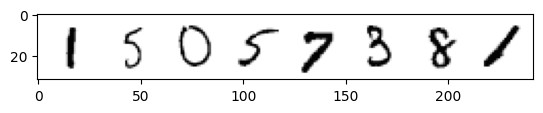

In [4]:
import matplotlib.pyplot as plt
train_loader = get_loader(image_size, batch_size, num_workers)
# Get a batch of training data
image, label = next(iter(train_loader))
print(image.shape, label.shape)
print(label)
# Convert the single-channel image to a 2D array
plt.imshow(make_grid(image)[0], cmap="Greys")

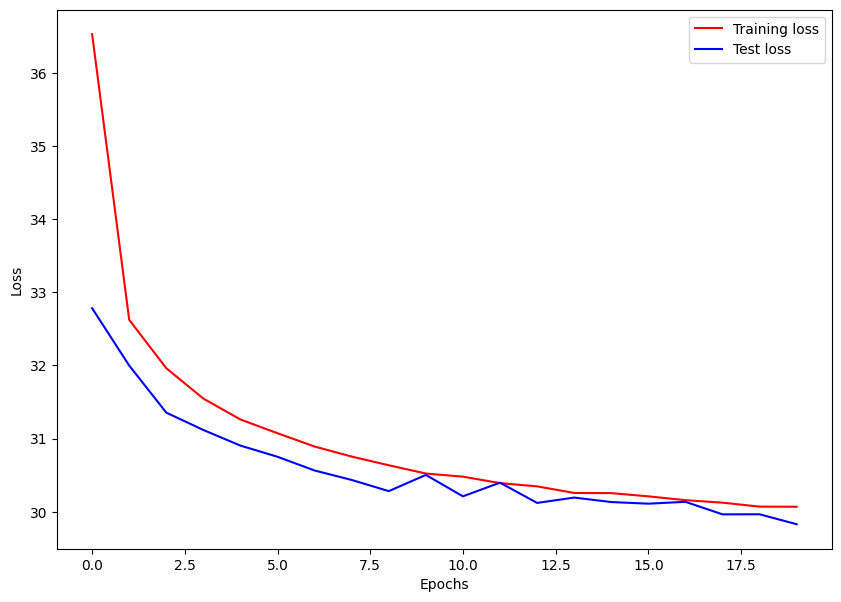

In [5]:
df = pd.read_csv("results/vae/vae_loss.csv")
plt.figure(figsize=(10, 7))
plt.plot(df["Train Loss"], label='Training loss', color='red') 
plt.plot(df["Test Loss"], label='Test loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
# @markdown Sampling some different digits:
from Models.vae import VAE
x = torch.randn(80, 1, 28, 28).to(device)
# y = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

model = VAE(image_size, latent_dim).to(device)
print(model)
model.load_state_dict(torch.load("checkpoints/vae.pth"))

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
  (fc_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=400, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


/tmp/ipykernel_77614/1552363907.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/vae.pth"))


<All keys matched successfully>

/tmp/ipykernel_77614/1357239888.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/vae.pth"))


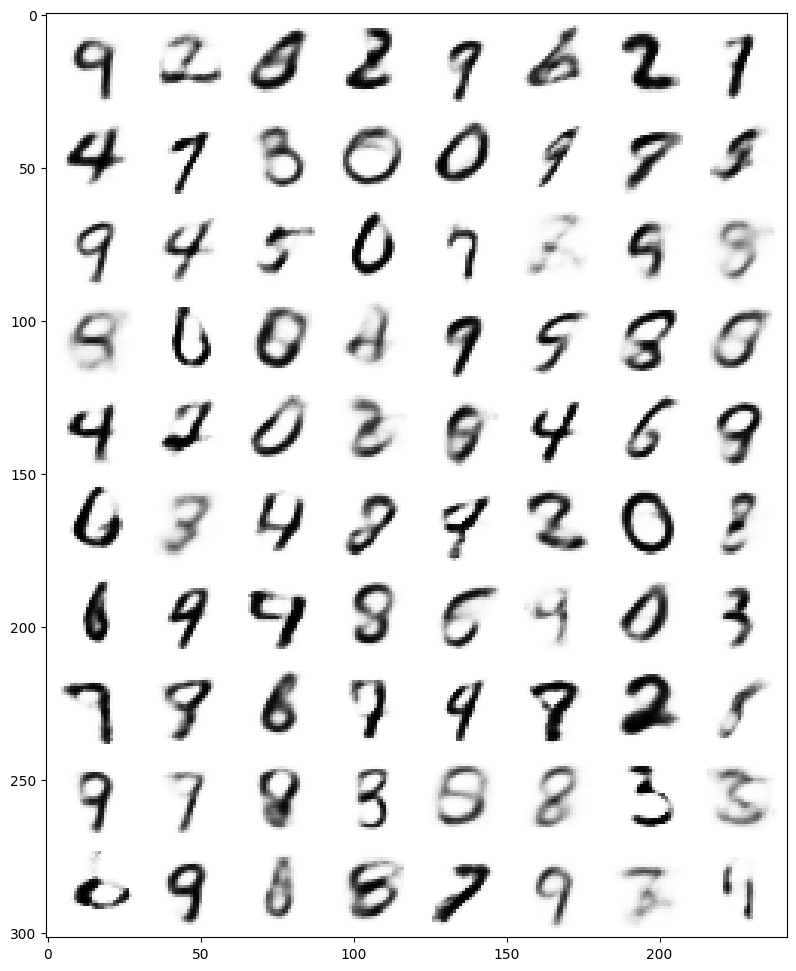

In [24]:
torch.manual_seed(118)
z = torch.randn(80, latent_dim).to(device)

model = VAE(image_size).cuda()
model.load_state_dict(torch.load("checkpoints/vae.pth"))

# 生成图像
with torch.no_grad():
    sample = model.decode(z).view(80, 1, image_size, image_size)

# 显示结果
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(make_grid(sample.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")


diffusion model

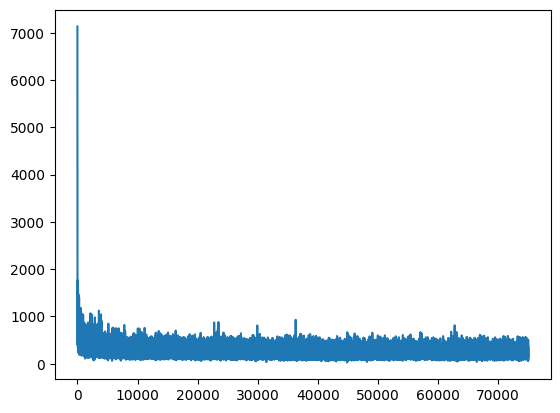

In [14]:
import pickle
with open("results/diffusion/diffusion_losses.pkl", "rb") as f:
    loss = pickle.load(f)
import matplotlib.pyplot as plt
plt.plot(loss)

/tmp/ipykernel_77614/3953012464.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/diffusion_model.pth"))
100%|██████████| 100

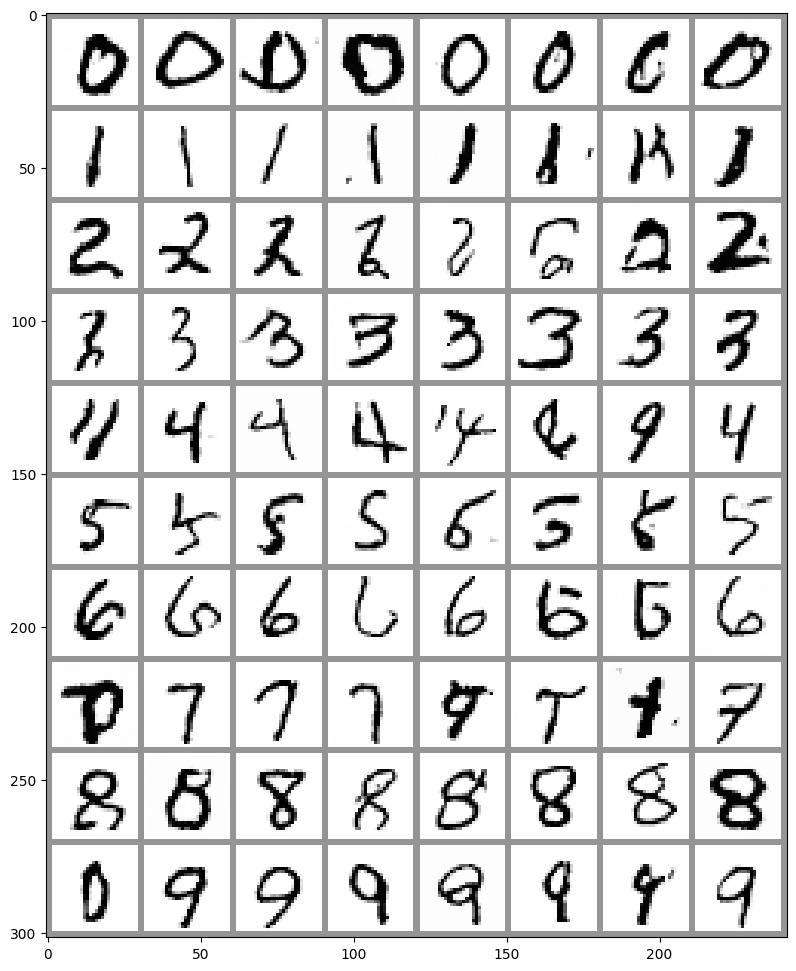

In [25]:
from Models.diffusion import noise_scheduler, ClassConditionedUnet
# Prepare random x to start from, plus some desired labels y
torch.manual_seed(118)
x = torch.randn(80, 1, image_size, image_size).to(device)
y = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

model = ClassConditionedUnet(image_size).cuda()
model.load_state_dict(torch.load("checkpoints/diffusion_model.pth"))

# Sampling loop
for t in tqdm(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")